In [1]:
# Cell 1: Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import f1_score
import numpy as np


from plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from data.processed_data import save_feature_data,load_feature_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
feature_df = load_feature_data()

# Separate features and target
X = feature_df.drop(columns=["SepsisLabel"], errors="ignore")
y = feature_df["SepsisLabel"]

Feature data loaded from feature_data.pkl


In [3]:
# Cell 4: Train/test split
neg_samples, pos_samples = y.value_counts()
print(f"Negative samples: {neg_samples}, Positive samples: {pos_samples}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Negative samples: 76055, Positive samples: 1360


In [4]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric="auc",
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.87844
[1]	validation_0-auc:0.91837
[2]	validation_0-auc:0.92847
[3]	validation_0-auc:0.93331
[4]	validation_0-auc:0.94287
[5]	validation_0-auc:0.94636
[6]	validation_0-auc:0.95302
[7]	validation_0-auc:0.95637
[8]	validation_0-auc:0.96102
[9]	validation_0-auc:0.96363
[10]	validation_0-auc:0.96844
[11]	validation_0-auc:0.97495
[12]	validation_0-auc:0.97853
[13]	validation_0-auc:0.98126
[14]	validation_0-auc:0.98241
[15]	validation_0-auc:0.98234
[16]	validation_0-auc:0.98302
[17]	validation_0-auc:0.98231
[18]	validation_0-auc:0.98441
[19]	validation_0-auc:0.98511
[20]	validation_0-auc:0.98559
[21]	validation_0-auc:0.98659
[22]	validation_0-auc:0.98762
[23]	validation_0-auc:0.98870
[24]	validation_0-auc:0.98924
[25]	validation_0-auc:0.98946
[26]	validation_0-auc:0.99008
[27]	validation_0-auc:0.99075
[28]	validation_0-auc:0.99066
[29]	validation_0-auc:0.99086
[30]	validation_0-auc:0.99103
[31]	validation_0-auc:0.99221
[32]	validation_0-auc:0.99234
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Subset ROC AUC (predicted=1 or actual=1): 0.833


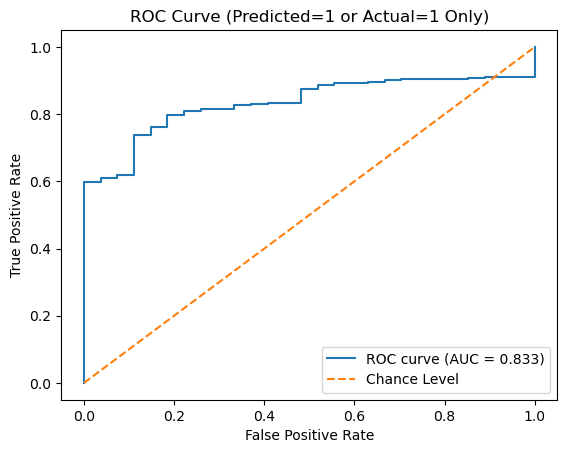

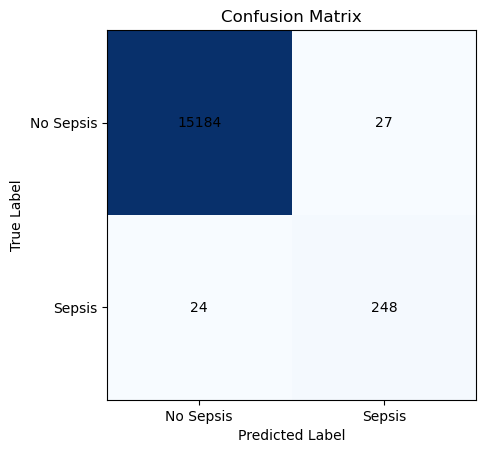


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15211
           1       0.90      0.91      0.91       272

    accuracy                           1.00     15483
   macro avg       0.95      0.95      0.95     15483
weighted avg       1.00      1.00      1.00     15483



In [5]:
# Cell 6: Evaluate model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC curve
plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [6]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold}, F1 Score: {max(f1_scores)}")

Optimal threshold: 0.6900000000000001, F1 Score: 0.9169811320754717


In [7]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

# Now evaluate using the new predictions
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15211
           1       0.94      0.89      0.92       272

    accuracy                           1.00     15483
   macro avg       0.97      0.95      0.96     15483
weighted avg       1.00      1.00      1.00     15483

[[15196    15]
 [   29   243]]
